# Prompt

Uber’s Driver team is interested in predicting which driver signups are most likely to start driving.
To help explore this question, we have provided a sample dataset of a cohort of driver signups.
The data was pulled a some time after they signed up to include the result of whether they
actually completed their first trip. It also includes several pieces of background information
gathered about the driver and their car.

In [1]:
#import needed libraries
%matplotlib inline
#basics
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

#train test split
from sklearn.model_selection import train_test_split

#model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

#model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

#model
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

## Part A
Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this
analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver
signups took a first trip within 30 days of signing up?

In [3]:
#load data
df = pd.read_csv('product_ds_exercise_2018_h2_dataset.csv')
# df.head(5)

In [4]:
#check for uniqueness of id

def check_uniqueness (df):
    print ('------------\n' + 'Total count of records:', len(df))
    print ('Number of Unique Driver Ids:', df.id.nunique(), '\n')

    temp = df.groupby('id').size().reset_index()

    for i in df.groupby('id').size().unique():
        print (len(temp[temp.iloc[:, 1] == i]), 'Id\'s occured', i, 'time(s)')

check_uniqueness(df)
check_uniqueness(df.drop_duplicates())

------------
Total count of records: 12357
Number of Unique Driver Ids: 11655 

11083 Id's occured 1 time(s)
458 Id's occured 2 time(s)
101 Id's occured 3 time(s)
10 Id's occured 4 time(s)
3 Id's occured 5 time(s)
------------
Total count of records: 11978
Number of Unique Driver Ids: 11655 

11355 Id's occured 1 time(s)
277 Id's occured 2 time(s)
23 Id's occured 3 time(s)


It seems like that we have some duplicate records in the original dataframe. With that in mind, we will create a deduped version of our data. We do see drivers with multiple signups (up to 3 times), which isn't unreasonable.

In [5]:
#DEDUPE
df.drop_duplicates(inplace = True)

In [6]:
#check for completeness of data
def check_completeness (df):
    temp = df.isnull().describe().T
    temp['pct'] = (temp.freq.astype('int') / temp['count'].astype('int')).map(lambda x : round(x,2))
    return temp

check_completeness (df)

,count,unique,top,freq,pct
id,11978,1,False,11978,1.00
city_name,11978,1,False,11978,1.00
signup_os,11978,2,False,6730,0.56
signup_channel,11978,2,False,10766,0.90
signup_timestamp,11978,2,False,10823,0.90
bgc_date,11978,2,False,7549,0.63
vehicle_added_date,11978,2,False,10750,0.90
vehicle_make,11978,2,False,11348,0.95
vehicle_model,11978,1,False,11978,1.00
vehicle_year,11978,1,False,11978,1.00


We see nulls in `signup_os`, `signup_channel`, `signup_timestamp`, `bgc_date`, `vehicle_added_date`, `vehicle_make`, and `first_completed_trip_timestamp`.

Out of the fields with nulls, only `signup_os`, `bgc_date`, and `first_completed_trip_timestamp` have more than 10% of the rows being nulls. `bgc_date` and `first_completed_trip_timestamp` have nulls that seem reasonable - drivers who didn't consent to background check and drivers who didn't complete trip. But nulls in `signup_os` may result from some system issue where certain devices aren't being recognized.

In [7]:
# df[df.vehicle_make.isnull()].head()
# df[df.signup_channel.isnull()].head()
# df[df.bgc_date.isnull()].head()
df[df.vehicle_added_date.isnull()].head()

,id,city_name,signup_os,signup_channel,signup_timestamp,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_trip_timestamp
20,e0513d05-942c-47d4-8102-2fff5d5307b1,Strark,mac,Organic,2017-07-25T20:41:45Z,2017-07-25T20:42:21Z,NaN,Honda,Accord,2017,2017-07-27T22:04:07Z
53,0cdda4e8-ad67-44c0-8786-3e054be20f28,Strark,ios web,Referral,2017-07-20T08:26:24Z,2017-07-20T08:27:08Z,NaN,Lexus,ES,2014,2017-07-24T18:02:07Z
67,85efbb0d-8773-4237-9232-99f3e4a28227,Wrouver,NaN,R2D,2017-07-11T14:21:38Z,NaN,NaN,Cadillac,Escalade,2005,2017-07-13T17:21:32Z
75,9b3f42ad-bc8a-44e9-b5cf-c2f1ad2430c5,Berton,NaN,R2D,NaN,NaN,NaN,Hyundai,Sonata,2011,2017-07-27T02:27:55Z
76,ad5d9d26-4b36-4d91-af18-316f1ddda79a,Strark,NaN,Referral,2017-07-31T21:53:51Z,2017-07-31T22:00:15Z,NaN,Mercedes-Benz,M-Class,2004,2017-08-18T16:02:38Z


Many of vehicle models with null vehicle makes don't seem to be real vehicle models. Besides that, no obvious data issue was found.

In [8]:
# df.dtypes

In [9]:
#parse correct datetime
df['signup_dt'] = pd.to_datetime(df.signup_timestamp.astype('str').map(lambda x: re.sub('[T,Z]', ' ', x).strip()))
df['vehicle_added_dt'] = pd.to_datetime(df.vehicle_added_date.astype('str').map(lambda x: re.sub('[T,Z]', ' ', x).strip()))
df['first_completed_trip_dt'] = pd.to_datetime(df.first_completed_trip_timestamp.astype('str').map(lambda x: re.sub('[T,Z]', ' ', x).strip()))
df.head()

,id,city_name,signup_os,signup_channel,signup_timestamp,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_trip_timestamp,signup_dt,vehicle_added_dt,first_completed_trip_dt
0,082befb0-c1de-4c14-8700-94a7943a7545,Strark,NaN,R2D,2017-07-06T20:42:17Z,NaN,2017-07-06T20:42:56Z,Volkswagen,CC,2012,NaN,2017-07-06 20:42:17,2017-07-06 20:42:56,NaT
1,1ae6156f-63fc-40cf-9734-0995978c4b6e,Berton,ios web,Dost,2017-07-03T17:41:07Z,2017-07-03T17:42:06Z,2017-07-03T17:41:14Z,Toyota,4Runner,2003,2017-07-23T00:26:50Z,2017-07-03 17:41:07,2017-07-03 17:41:14,2017-07-23 00:26:50
2,2a4a4eef-14ef-4ceb-82eb-66f1f7d0d219,Berton,NaN,R2D,2017-07-10T22:55:29Z,NaN,2017-07-11T17:44:44Z,Hyundai,Elantra,2015,NaN,2017-07-10 22:55:29,2017-07-11 17:44:44,NaT
3,56fe7597-3ad8-4798-8be8-5fbc4e2d3151,Berton,ios web,Referral,2017-07-27T18:27:21Z,2017-07-27T18:31:43Z,2017-07-27T18:31:09Z,Honda,Civic,2017,2017-07-31T04:07:24Z,2017-07-27 18:27:21,2017-07-27 18:31:09,2017-07-31 04:07:24
4,67370341-68a5-415f-acf2-be58832a8f9c,Wrouver,other,Referral,2017-07-17T22:20:35Z,2017-07-17T22:21:09Z,2017-07-17T22:20:53Z,Honda,Accord,1999,NaN,2017-07-17 22:20:35,2017-07-17 22:20:53,NaT


In [10]:
#distribution of vehicle year
df.vehicle_year.describe()

count    11978.000000
mean      2011.567874
std          4.913779
min       1993.000000
25%       2008.000000
50%       2013.000000
75%       2016.000000
max       2018.000000
Name: vehicle_year, dtype: float64

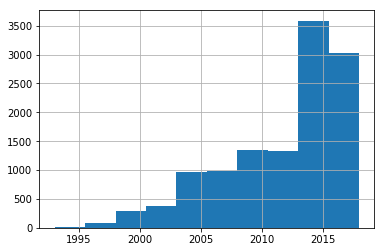

In [11]:
df.vehicle_year.hist()

Most vehicle are new vehicles. `vehicle year` ranges from 1993 to 2018

Text(0,0.5,'Number of Signups')

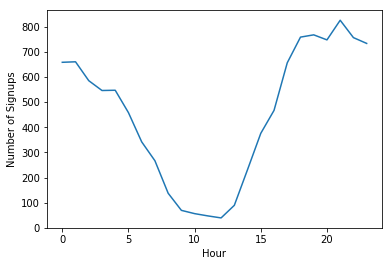

In [12]:
#sign up by hour
df.groupby(df.signup_dt.dt.hour).id.count().plot()
plt.xlabel("Hour")
plt.ylabel("Number of Signups")

Assuming that all time was recorded in the same timezone, tt seems like signups peak at night between 5pm - 11pm and drop to the lowest during noon

Text(0,0.5,'Number of Trips')

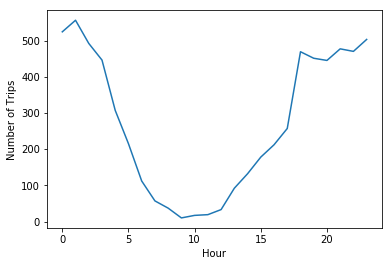

In [13]:
#first trip by hour
df.groupby(df.first_completed_trip_dt.dt.hour).id.count().plot()
plt.xlabel("Hour")
plt.ylabel("Number of Trips")

Assuming that all time was recorded in the same timezone, hour for first completed trips follows very similar distribution as the signups.

### What fraction of the driver signups took a first trip within 30 days of signing up?

We know that 1) certain drivers signed up multiple times and 2) there are 10% of the sign up where we don't have any sign up timestamp. Here we assume to 1) treat each different signup as unique driver signup and 2) consider a record with a trip completion timestamp but without a signup timestamp to still be a valid record of driver signup and 3) we are not missing any datetime for the first trip completion for each sign up

In [14]:
#day difference between signup and first trip
df['signup_firsttrip_daydiff'] = (df.first_completed_trip_dt - df.signup_dt).astype('timedelta64[D]')                                         
# df.head()

In [15]:
#check to see whether all day difference are within 30 days
(df.signup_firsttrip_daydiff <= 30).sum() / (df.signup_firsttrip_daydiff.notnull().sum())

1.0

Looks good

In [16]:
# % of signups with a completed trip in 30 days
df.first_completed_trip_dt.notnull().mean()

0.5435798964768743

With the assumptions we made above, we see that **54% of the driver signups had a completed trip within 30 days.**

## Part B 
Build a predictive model to help Uber determine whether or not a driver signup will start driving
within 30 days of signing up. Discuss why you chose your approach, what alternatives you
considered, and any concerns you have. How valid is your model? Include any key indicators of
model performance.

### Feature Engineering

Most of the features we currently have are categorical values with null values. We can use one-hot encoding for each level of these values (with one level left out, e.g. nulls for columns with nulls) to avoid perfect collinearity) to include all these different categories. 

The only continuous feature (including time variables) without null values is vehicle year, which can be included as a feature. Otherwise for the variables with null values, we'd have to either populate the null values, which we have very little context on how we should do so, or divide the dataset into subsets of data where records with null values are grouped separately. 

In [17]:
# df.head()

In [18]:
#feature engineering

#add day of week for signup
df['signup_dow'] = df.signup_dt.dt.weekday_name

def construct_ft_label_mat(df):
    
    #features
    #categorical features
    data_mat = pd.get_dummies(df[['city_name', 'signup_os', 'signup_channel', 'vehicle_make', 'signup_dow']])
    
    #Not Null Features (might create multicolllinearity for regression)
    data_mat['has_city_name'] = df.city_name.notnull() * 1
    data_mat['has_signup_os'] = df.signup_os.notnull() * 1
    data_mat['has_signup_channel'] = df.signup_channel.notnull() * 1
    data_mat['has_vehicle_make'] = df.signup_channel.notnull() * 1
    data_mat['has_signup_ts'] = df.signup_timestamp.notnull() * 1
    data_mat['has_vehicle_added_ts'] = df.vehicle_added_date.notnull() * 1
    
    #vehicle age
    data_mat['vehicle_age'] = df.vehicle_year.map(lambda x: 2018 - x)
    
    #consent to background check
    data_mat['has_bgc_date'] = df.bgc_date.notnull() * 1
    
    #whether has vehicle added dt
    data_mat['has_vehicle_added_date'] = df.vehicle_added_date.notnull() * 1
    
    #labels
    data_mat['complete_first_trip_30d'] = df.first_completed_trip_timestamp.notnull() * 1
    
    return data_mat

In [19]:
df_all = construct_ft_label_mat(df)
df_all.shape

(11978, 79)

In [20]:
#features
feature_all = df_all.iloc[:, :-1]
#labels
label_all = df_all.iloc[:, -1]

Without further feature selection, we have 78 features in our dataset for prediction. Now let's split the data to train and test sets. One thing we saw from Part A is that we have a **fairly balanced dataset** with around half of the sample being postive. Hence, no sophisticated sampling methods is needed here. 

In [21]:
#train test split
train_data, test_data, train_label, test_label = train_test_split (feature_all, label_all, test_size = 0.25, random_state = 15)

### Metric Selection
Since this is a binary classification task with a balanced dataset, Area Under Curve would be a good quantifiable metric to be used to evaluate the performance of the model. AUC of a classifier is equal to the probability that the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. F1 score will be better suited if our data is imbalanced. 

### Model Selection & Tuning 1 (Linear)
This is by nature a binary classification task and with the one-hot encodings + the continuous feature (vehicle age). Logistic Regression can be served as a useful model as a linear classifier in this case which predicts the likelihood of a given signup ending up with a completed trip within 30 days.

I chose to use a grid search with cross-validation to tune the hyperparameters that would produce the best AUC. 

In [107]:
lr = LogisticRegression()
parameters = {'C':np.linspace(0.0005, 0.1, 100), 'penalty' : ['l1', 'l2']}

#use stratified k-fold to preserve % of sample for each class
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 1001)

#grid search
clf = GridSearchCV(lr, parameters,cv=skf.split(train_data, train_label))
clf.fit(train_data, train_label)

#prediction
pred_test_prob_lr = clf.predict_proba(test_data)[:,1]

print(clf.best_params_)
roc_auc_score(test_label, pred_test_prob_lr)

{'C': 0.07085353535353535, 'penalty': 'l1'}


0.5839643817204301

### Model Selection & Tuning 2 (Non-Linear)
Hoping to capture potential non-linear relationship between our dependent variable and the features, we experiment with a non-linear method - the xgboost variant of gradient boosting. With an ensemble method where decision trees are grown sequentially, with a randomly sampled data and features, to correct the prediction error from the previous tree, we hope to increase the test AUC by better balancing the bias-variance trade-off.

A grid search with cross-validation is also used to tune the hyperparameters.

In [110]:
parameters = {
         'learning_rate': [.01, .02, .03],
          'min_child_weight': [1, 5],
          'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
         }

xgb_test = xgb.XGBClassifier(objective = 'binary:logistic',
            max_depth = 3, subsample = 0.8, max_delta_step = 1, random_state = 15, silent=True)

#grid search
grid_search = GridSearchCV(xgb_test, param_grid = parameters, scoring='roc_auc', cv=skf.split(train_data, train_label))
grid_search.fit(train_data, train_label)

#prediction
pred_test_prob_xgb = grid_search.predict_proba(test_data)[:,1]

print(grid_search.best_params_)
roc_auc_score(test_label, pred_test_prob_xgb)

{'colsample_bytree': 0.8, 'learning_rate': 0.03, 'min_child_weight': 5}


0.577905017921147

### Model ROC Curves

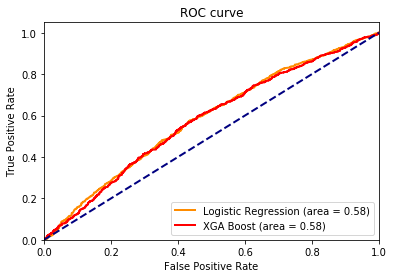

In [123]:
def plot_roc(y_test, label, y_score, label2, y_score2):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y_test, y_score)
    roc_auc[0] = auc(fpr[0], tpr[0])

    fpr[1], tpr[1], _ = roc_curve(y_test, y_score2)
    roc_auc[1] = auc(fpr[1], tpr[1])
    
    plt.figure()
    lw = 2
    
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label=label + ' (area = %0.2f)' % roc_auc[0])
    
    plt.plot(fpr[1], tpr[1], color='red',
             lw=lw, label= label2 + ' (area = %0.2f)' % roc_auc[1])
        
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(test_label, "Logistic Regression", pred_test_prob_lr, "XGA Boost", pred_test_prob_xgb)

### Model Confusion Matrices

In [125]:
print("confusion matrix for Logistic Regression:")
print(confusion_matrix(test_label, pred_test_prob_lr > 0.5))

print("confusion matrix for XGA Boost:")
print(confusion_matrix(test_label, pred_test_prob_xgb > 0.5))

confusion matrix for Logistic Regression:
[[ 649  746]
 [ 558 1042]]
confusion matrix for XGA Boost:
[[ 600  795]
 [ 514 1086]]


From the ROC curves and confusion matrices, it seems like our two models have very similar performance on the test set, with logistic regression making slightly more False Positives and less False Negatives. 

In a scenario where there is not a clear winner, I tend to **prefer the simpler(est) model** and in this case, it'd be our model 1 - **logistic regression**. 

Although the AUC is far from desired, additional data and features, including features that could be derived from the data we have, may help improve the AUC for the classification task.

### Feature Importance

In [130]:
#recreate best Logistic Regression
lr2 = LogisticRegression(C = 0.07085353535353535, penalty = 'l1')
lr2.fit(train_data, train_label)

#get features with 
# train_data.columns()
# = lr2.coef_

LogisticRegression(C=0.07085353535353535, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [160]:
#feature importance
feat_imp = pd.DataFrame({'feature': np.array(train_data.columns),
                         'coef': lr2.coef_.reshape(78,),
                         'abs_coef': np.absolute(lr2.coef_).reshape(78,)
                        })

#features sorted by feature importance according to the LR model
feat_imp[feat_imp.coef != 0].sort_values(by = 'abs_coef', ascending = False)

,abs_coef,coef,feature
12,0.554971,0.554971,signup_channel_Referral
71,0.115901,-0.115901,has_signup_channel
72,0.110747,-0.110747,has_vehicle_make
2,0.078505,0.078505,city_name_Wrouver
69,0.063705,0.063705,has_city_name
4,0.061940,0.061940,signup_os_ios web
26,0.048253,0.048253,vehicle_make_Honda
70,0.040707,0.040707,has_signup_os
63,0.039743,0.039743,signup_dow_Monday
64,0.038573,0.038573,signup_dow_Saturday


## Part C
Briefly discuss how Uber might leverage the insights gained from the model to generate more
first trips (again, a few ideas/sentences will suffice).

From the feature importance in the best logistic regression model, we can see that the 10 most  important features are as followed:

In [164]:
feat_imp[feat_imp.coef != 0].sort_values(by = 'abs_coef', ascending = False)[['feature', 'coef']].head(10)

,feature,coef
12,signup_channel_Referral,0.554971
71,has_signup_channel,-0.115901
72,has_vehicle_make,-0.110747
2,city_name_Wrouver,0.078505
69,has_city_name,0.063705
4,signup_os_ios web,0.061940
26,vehicle_make_Honda,0.048253
70,has_signup_os,0.040707
63,signup_dow_Monday,0.039743
64,signup_dow_Saturday,0.038573


One note of interpreting these coefficients is that these are correlations but not causations. The interpretation is that "holding other variables constant, a 1 unit increase in [feature] changes the odds of a signup -> 30-day trip conversion by $e^{coef}$ times". But that doesn't neccessarily mean that, for example, forcing users to drive Honda is going to change the odds by $e^{0.05} = 1.05$ times since it's not a causal effect.

With that in mind, here are a couple of ideas that Uber could try to operationalize in order to generate more first trips:

>1. Provide incentive for Uber drivers to refer new Uber drivers

>2. Increase driver recruiting effort in Wrouver, where drivers in average have a higher signup to trip completion conversion

>3. Understand and improve user singup experience on platforms other than IOS Web. Understand why signing up using IOS web correlates to better conversion. 
